- https://medium.com/@vanillaxiangshuyang/self-supervised-learning-on-tabular-data-with-tabnet-544b3ec85cee
- https://colab.research.google.com/drive/1P8Obe07DP3VeOld08ThyT1HnChLip_LO#scrollTo=gvy9vUUNOP0W

- https://www.kaggle.com/code/sisharaneranjana/semi-supervised-pre-training-with-tabnet#%F0%9F%94%8FDescription-of-the-dataset-
- https://dacon.io/en/codeshare/3837

In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# # 데이터 전처리
# # Time 을 일중 시간으로 변환
# df.loc[:, "Time"] = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24)

# # Amount column 은 편차가 크므로 log-scale 로 변환
# eps=0.001
# df['Amount'] = np.log(df.pop('Amount') + eps)

# 전처리 된 데이터 불러오기

In [3]:
with open("./dataset/creditcard.pkl","rb") as file:
    data = pickle.load(file)

In [4]:
df = data.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# train_test_split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
features = df.values
labels = np.array(df.pop('Class'))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("===============")
print("X validation shape: ", X_val.shape)
print("y validation shape: ", y_val.shape)
print("===============")
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (139554, 31)
Y train shape:  (139554,)
X validation shape:  (59810, 31)
y validation shape:  (59810,)
X test shape:  (85443, 31)
Y test shape:  (85443,)


In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val= sc.transform(X_val)

# Network parameters

- https://github.com/dreamquark-ai/tabnet
- https://github.com/dreamquark-ai/tabnet/blob/develop/pretraining_example.ipynb

In [9]:
import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

In [10]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
#     cat_idxs=cat_idxs,
#     cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

# Self Supervised Training

In [11]:
max_epochs = 100

In [12]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
)

epoch 0  | loss: 1.29573 | val_0_unsup_loss_numpy: 0.9893800020217896|  0:00:09s
epoch 5  | loss: 0.93936 | val_0_unsup_loss_numpy: 0.9921900033950806|  0:00:53s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 0.9893800020217896


In [13]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_val)
assert(reconstructed_X.shape==embedded_X.shape)

In [14]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_val)

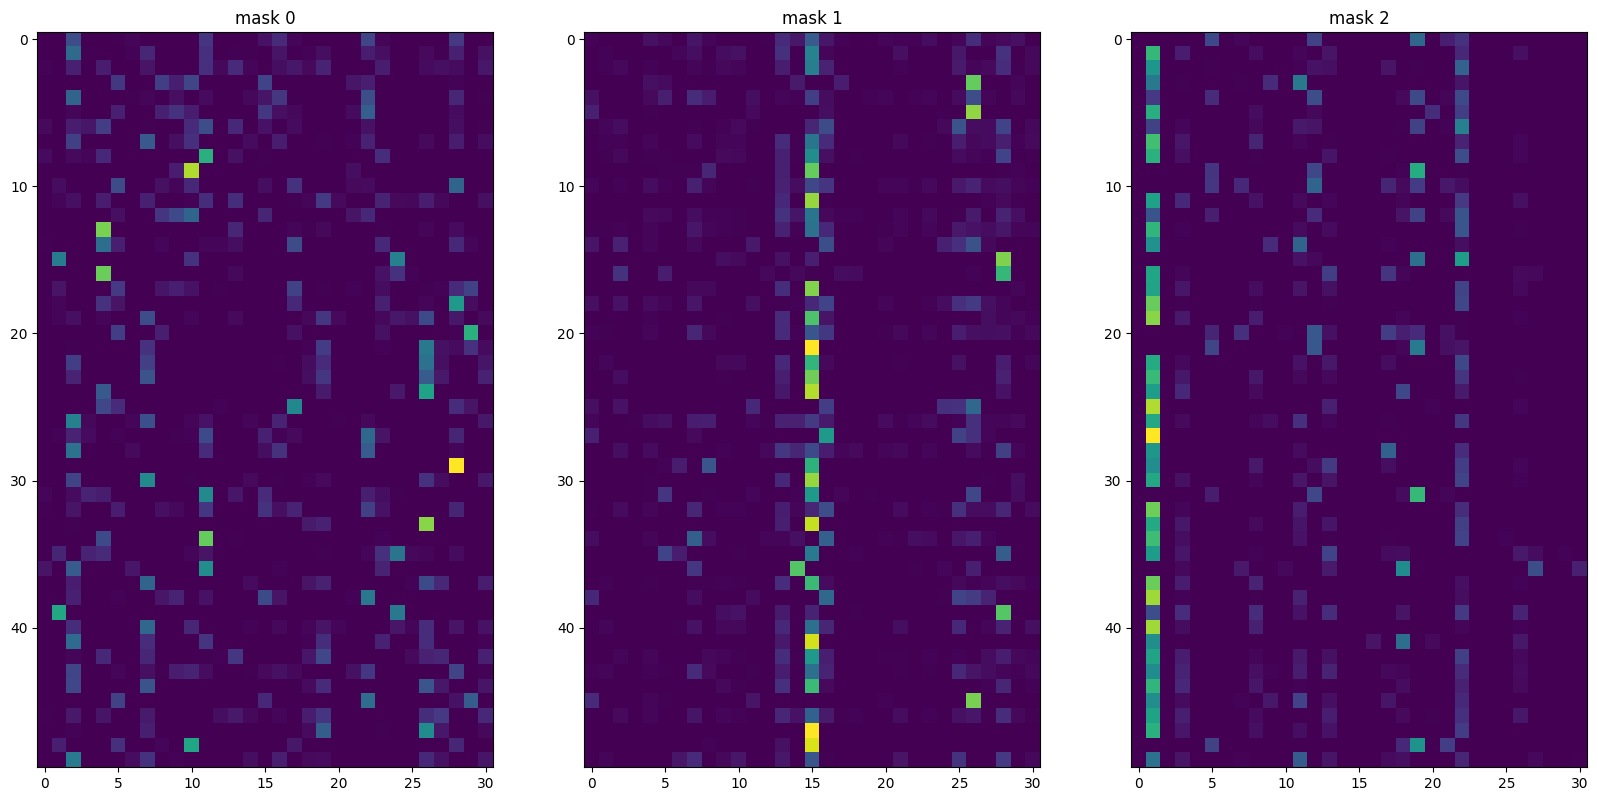

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Save and load the same way as other TabNet models

In [16]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


# Training

In [17]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

In [18]:
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import f1_score

class F1_Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1)
        return score

In [19]:
from pytorch_tabnet.metrics import Metric

class F1_score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_score = np.where(y_score > 0.5, 1, 0)
        y_score = y_score[:,1]
        return f1_score(y_true, y_score, average="weighted")

In [20]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','f1'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

epoch 0  | loss: 0.20829 | train_logloss: 0.06555 | train_f1: 0.20383 | valid_logloss: 0.06416 | valid_f1: 0.21011 |  0:00:11s
epoch 5  | loss: 0.00206 | train_logloss: 0.00154 | train_f1: 0.91797 | valid_logloss: 0.00172 | valid_f1: 0.91064 |  0:01:11s
epoch 10 | loss: 0.00124 | train_logloss: 0.00011 | train_f1: 0.98947 | valid_logloss: 0.00023 | valid_f1: 0.98198 |  0:02:11s
epoch 15 | loss: 0.00099 | train_logloss: 0.00013 | train_f1: 0.99576 | valid_logloss: 0.00021 | valid_f1: 0.99091 |  0:03:11s
epoch 20 | loss: 0.00084 | train_logloss: 1e-05   | train_f1: 1.0     | valid_logloss: 4e-05   | valid_f1: 0.99539 |  0:04:11s
epoch 25 | loss: 0.00066 | train_logloss: 1e-05   | train_f1: 1.0     | valid_logloss: 4e-05   | valid_f1: 0.99539 |  0:05:12s
epoch 30 | loss: 0.00057 | train_logloss: 1e-05   | train_f1: 1.0     | valid_logloss: 3e-05   | valid_f1: 0.99543 |  0:06:12s
epoch 35 | loss: 0.00049 | train_logloss: 1e-05   | train_f1: 1.0     | valid_logloss: 1e-05   | valid_f1: 1.0 

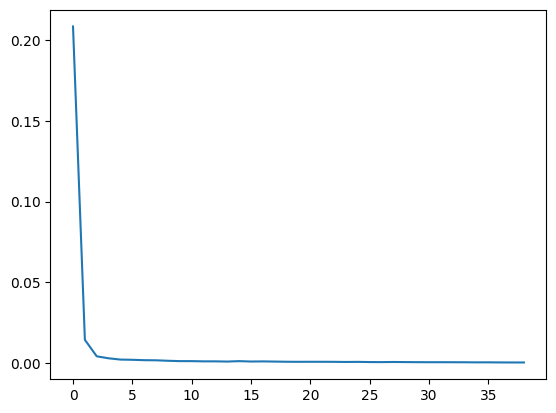

In [21]:
# plot losses
plt.plot(clf.history['loss'])

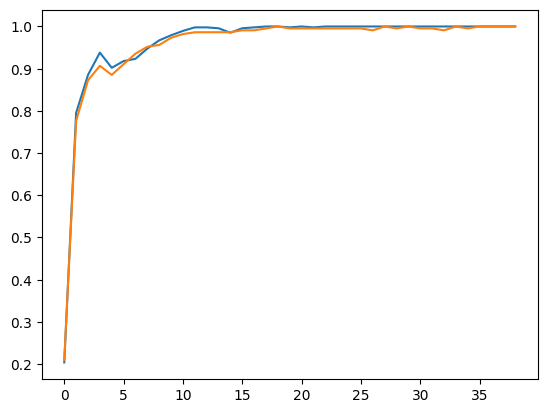

In [22]:
# plot auc
plt.plot(clf.history['train_f1'])
plt.plot(clf.history['valid_f1'])

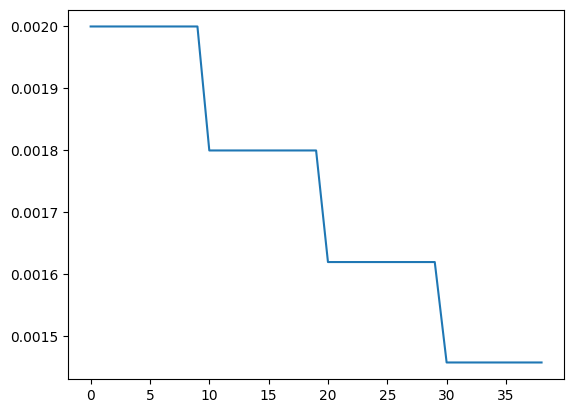

In [23]:
# plot learning rates
plt.plot(clf.history['lr'])

# Predictions

In [24]:
# preds = clf.predict_proba(X_test)
preds = clf.predict(X_test)
test_f1 = f1_score(preds, y_test)

preds_val = clf.predict(X_val)
valid_f1 = f1_score(preds_val, y_val)

print("BEST VALID SCORE : ", clf.best_cost)
print("FINAL TEST SCORE : ", test_f1)

BEST VALID SCORE :  1.0
FINAL TEST SCORE :  0.9966329966329966


In [25]:
# check that best weights are used
assert np.isclose(valid_f1, np.max(clf.history['valid_f1']), atol=1e-6)

# Save and load Model

In [26]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [27]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [28]:
# loaded_preds = loaded_clf.predict_proba(X_test)
loaded_preds = loaded_clf.predict(X_test)
loaded_test_f1 = f1_score(loaded_preds, y_test)

print("FINAL TEST SCORE : ",loaded_test_f1)

FINAL TEST SCORE :  0.9966329966329966


In [29]:
assert(test_f1 == loaded_test_f1)

# Global explainability : feat importance summing to 

In [30]:
clf.feature_importances_

array([8.12829949e-07, 2.94905892e-01, 8.96544115e-03, 1.23060893e-04,
       4.45257041e-02, 7.09905085e-04, 7.95922569e-06, 1.00241629e-02,
       1.92790022e-02, 1.10047102e-02, 1.23582193e-01, 9.31756053e-03,
       2.10987936e-02, 3.64702337e-04, 9.43152630e-02, 6.27713129e-03,
       2.41614023e-01, 1.07682022e-02, 4.40770390e-05, 6.97589449e-05,
       3.02075005e-04, 1.32499809e-03, 1.60042224e-02, 5.86784179e-05,
       1.18430670e-05, 4.10332215e-04, 5.19294243e-04, 7.95564789e-05,
       2.33819509e-04, 8.87950829e-04, 8.31688743e-02])

# Local explainability and masks

In [31]:
explain_matrix, masks = clf.explain(X_test)

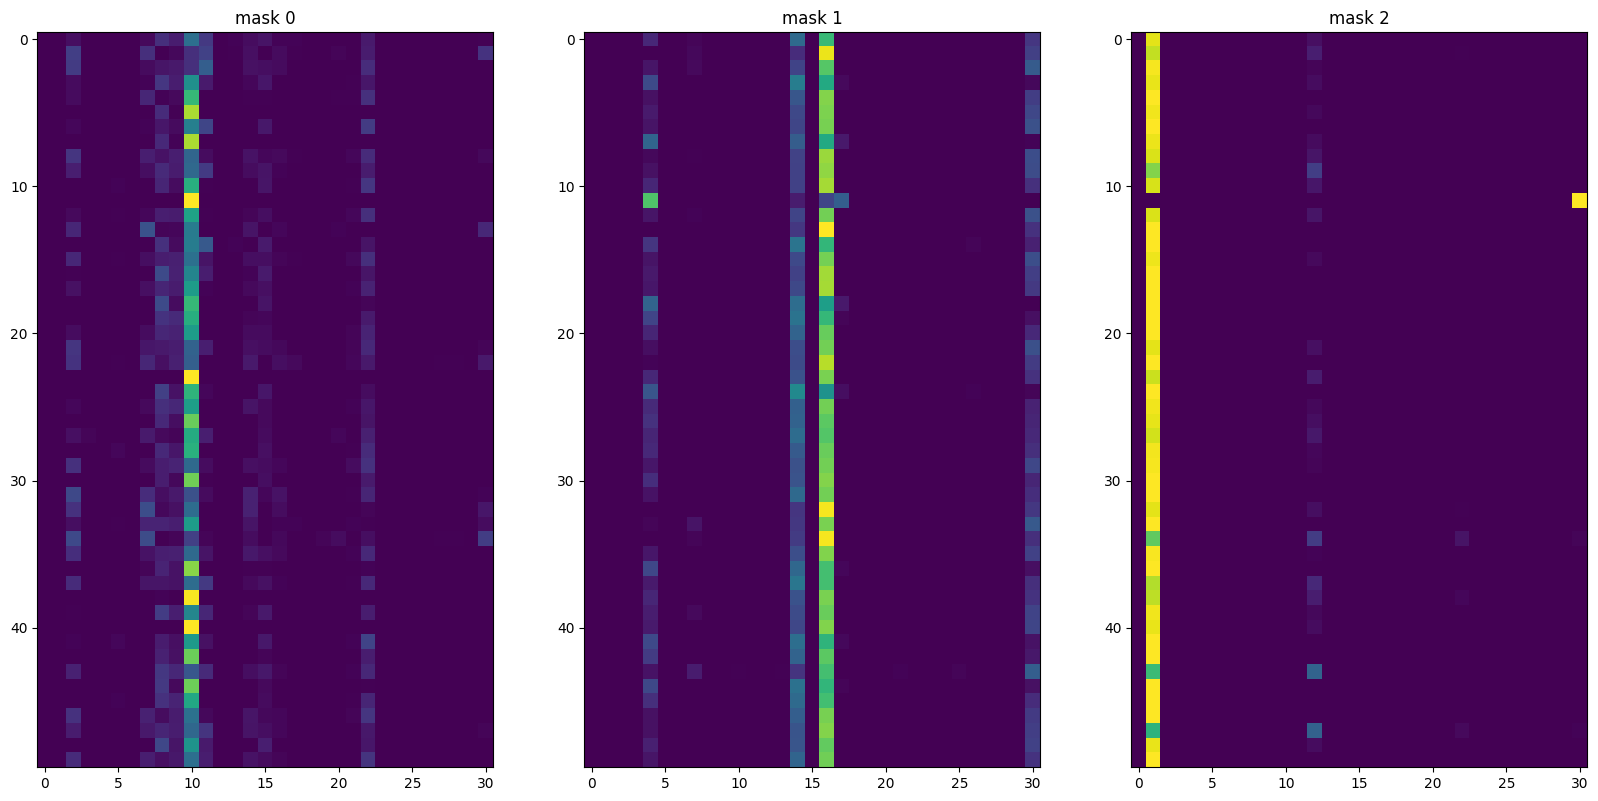

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Pre-trained 된 모델로 test
- ctgan_generated로 test

In [33]:
generated = pd.read_csv('./dataset/ctgan_generated.csv')
generated.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,26,0.526711,0.506531,2.323598,0.538318,-1.445373,0.567182,-1.134017,0.933505,0.585911,...,-0.105562,-0.587608,-0.065944,0.043478,0.131319,-0.477668,-0.023228,0.187240,183.84,0
1,26,-1.000721,-0.689407,0.491482,-0.399631,-0.331155,-1.191797,-0.904256,0.242771,-1.002102,...,0.312251,-0.557088,-0.054971,0.938367,0.010017,-0.208705,0.049386,0.027675,1.00,0
2,26,0.879617,-0.585084,1.342711,0.319722,-0.971214,-1.719158,-1.033463,0.218678,-1.085625,...,0.122075,-1.169211,-0.596052,0.107330,0.443202,1.119314,0.089819,0.034891,1.00,0
3,33,1.056257,0.958284,1.306321,-2.260671,-0.225238,-0.092485,0.356266,-0.023558,1.165119,...,0.022474,0.578880,-0.235727,0.961696,0.346246,0.352786,0.328290,0.015913,29.68,0
4,41,0.827262,-0.251887,-0.684657,-0.076610,-0.479253,-0.162641,-1.105629,0.219017,-1.084473,...,0.318296,-0.496126,-0.114626,1.008221,0.186005,0.531161,0.033279,0.050230,1.00,0


In [34]:
# 데이터 전처리
ctgan = generated.copy()

# Time 을 일중 시간으로 변환
ctgan.loc[:, "Time"] = ctgan.loc[:, "Time"].apply(lambda x : x / 3600 % 24)

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001
ctgan['Amount'] = np.log(ctgan.pop('Amount') + eps)

ctgan.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.007222,0.526711,0.506531,2.323598,0.538318,-1.445373,0.567182,-1.134017,0.933505,0.585911,...,-0.105562,-0.587608,-0.065944,0.043478,0.131319,-0.477668,-0.023228,0.187240,0,5.214071
1,0.007222,-1.000721,-0.689407,0.491482,-0.399631,-0.331155,-1.191797,-0.904256,0.242771,-1.002102,...,0.312251,-0.557088,-0.054971,0.938367,0.010017,-0.208705,0.049386,0.027675,0,0.001000
2,0.007222,0.879617,-0.585084,1.342711,0.319722,-0.971214,-1.719158,-1.033463,0.218678,-1.085625,...,0.122075,-1.169211,-0.596052,0.107330,0.443202,1.119314,0.089819,0.034891,0,0.001000
3,0.009167,1.056257,0.958284,1.306321,-2.260671,-0.225238,-0.092485,0.356266,-0.023558,1.165119,...,0.022474,0.578880,-0.235727,0.961696,0.346246,0.352786,0.328290,0.015913,0,3.390507
4,0.011389,0.827262,-0.251887,-0.684657,-0.076610,-0.479253,-0.162641,-1.105629,0.219017,-1.084473,...,0.318296,-0.496126,-0.114626,1.008221,0.186005,0.531161,0.033279,0.050230,0,0.001000


In [35]:
ctgan_features = ctgan.values
ctgan_labels = np.array(ctgan.pop('Class'))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(ctgan_features, ctgan_labels, test_size=0.3, random_state=0, stratify=ctgan_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [37]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

In [38]:
clf.fit(X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','f1'],
)

epoch 0  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 1  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 2  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 3  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 4  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 5  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 6  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39506 |  0:00:00s
epoch 7  | loss: 0.0     | train_logloss: 0.8661  | train_f1: 0.26415 | valid_logloss: 1.15551 | valid_f1: 0.39

In [39]:
predicted_test=clf.predict(X_test)
score=f1_score(y_test,predicted_test)
print(score)

0.3146067415730337


In [40]:
### predict, predic_proba, predict_classes